# AIPI 590 - XAI | Assignment #06
### Adversarial Patches
### Peter Banyas



[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/banyasp/aipi590_hw6_adversarial_patch/blob/main/main.ipynb)
https://colab.research.google.com/github/banyasp/aipi590_hw6_adversarial_patch/blob/main/main.ipynb

## See ./cursor_logs for AI interactions

## the real work for this assignment starts halfway down the notebook

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Duke-AI-XAI" # Change to your repo name
git_path = 'https://github.com/AIPI-590-XAI/Duke-AI-XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'templates'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'Duke-AI-XAI' already exists and is not an empty directory.
/content/Duke-AI-XAI/templates
'=1.4'   Duke-AI-XAI/   template.ipynb


## Imports

In [2]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
# Try to use notebook version for better Jupyter integration, fallback to regular tqdm
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
# Prioritize GPU acceleration: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device", device)

/tmp/ipython-input-2826276278.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


# **getting acquainted, not the patch training yet**
### This section drawn from code from Brinnae Bent's github repo

#### download dataset and pretrained patches

In [3]:
import urllib.request
from urllib.error import HTTPError, URLError
import ssl
import zipfile
import certifi

# Create an SSL context using certifi's certificate bundle for proper SSL verification
# This fixes SSL certificate verification issues on macOS by using the certifi package
ssl_context = ssl.create_default_context(cafile=certifi.where())

# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            # Use the SSL context with proper certificate verification
            opener = urllib.request.build_opener(urllib.request.HTTPSHandler(context=ssl_context))
            urllib.request.install_opener(opener)
            urllib.request.urlretrieve(file_url, file_path)
        except (HTTPError, URLError) as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

### Pulling in the ImageNet pretrained model (victim/target model)

In [4]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 110MB/s]


#### Pull in 5 images for each of the 1000 classes in the ImageNet database

In [5]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### verify performance of model

In [6]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [7]:
acc, top5 = eval_model(data_loader)
print(acc, top5)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%
0.8062 0.9562


In [8]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

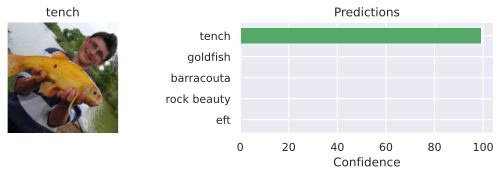

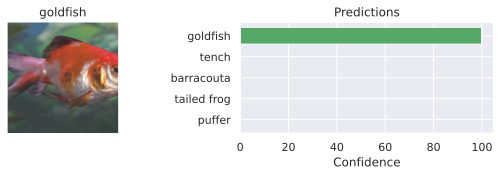

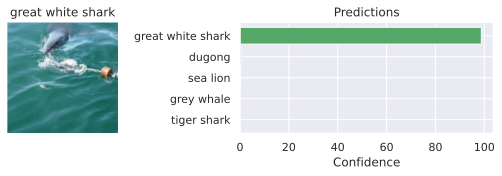

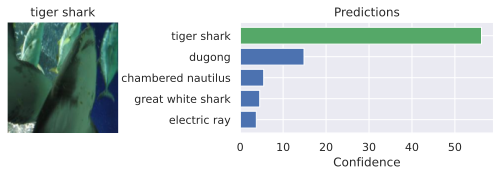

In [9]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

# FGSM attack

In [10]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

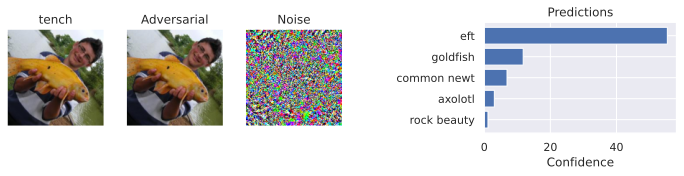

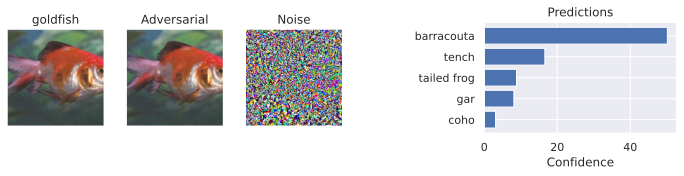

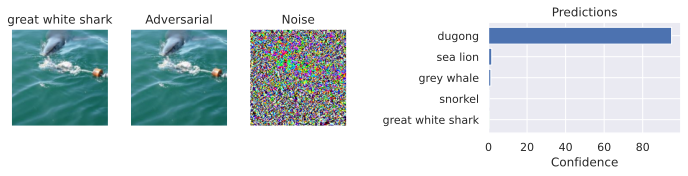

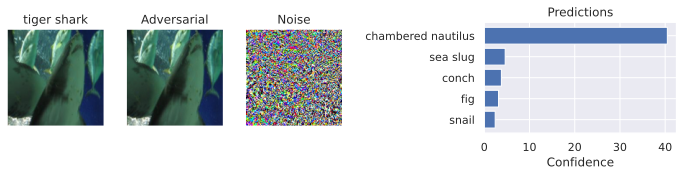

In [11]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.02)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

In [12]:
_ = eval_model(data_loader, img_func=lambda x, y: fast_gradient_sign_method(pretrained_model, x, y, epsilon=0.02)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Top-1 error: 93.74%
Top-5 error: 60.82%


# **Getting acquainted with Adversarial Patches but not building for real yet**
### This section drawn from Brinnae Bent's github repo + also with the help of Cursor, Oct 31-Nov 2.

## Strategy
1. Find the gradients for the input -- but only for the pixels in the patch.
2. Update the gradient values in the adversarial direction.
We want this patch to work for any background.

The optimal patch is the patch that maximizes

the expected value

(over all background images, all patch transformations, and all patch locations)

of log( Probability( the model guesses your target class | that combo of patch, background, transformation, & location ))

In [13]:
# from brinnae bent's github repo
# Bound the image values
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

# actually replace the pixels in the image with the patch
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [14]:
# from brinnae bent's github repo
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

actually train the patch

In [15]:
# from brinnae bent's github repo
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

Load in some pretrained patches

In [16]:
# from brinnae bent's github repo
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

to save results when training new patches

In [17]:
# from brinnae bent's github repo
# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [18]:
# from brinnae bent's github repo
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

In [19]:
# from brinnae bent's github repo
class_names = ['toaster', 'goldfish', 'school bus', 'lipstick', 'pineapple']
patch_sizes = [32, 48, 64]

patch_dict = get_patches(class_names, patch_sizes)
# save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

In [20]:
# from brinnae bent's github repo
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

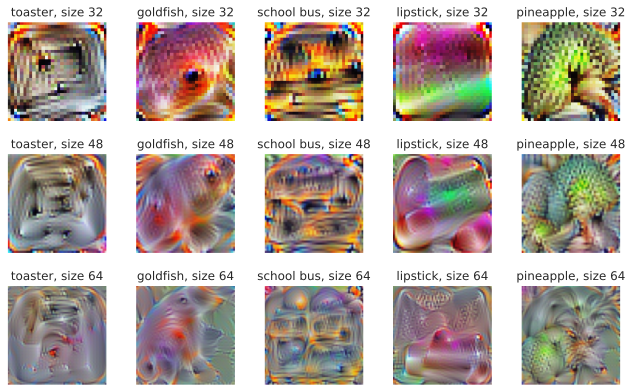

In [21]:
show_patches()

In [22]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [23]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

how often does the patch make the model's top prediction class = target class?

In [24]:
show_table(top_1=True)

how often does the patch yield the target class within the top 5 classes that the model thinks of?

In [25]:
show_table(top_1=False)

In [26]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

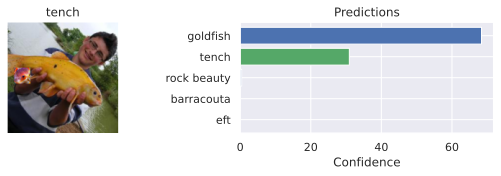

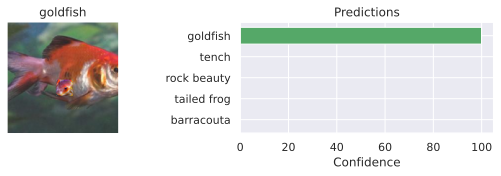

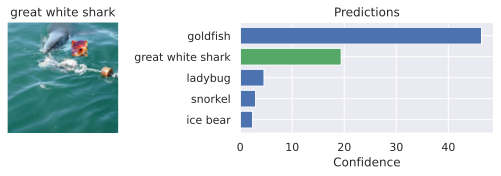

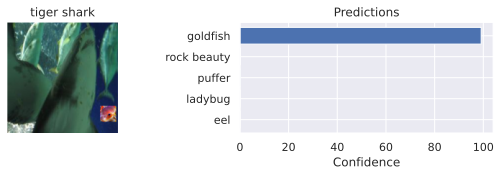

In [27]:
perform_patch_attack(patch_dict['goldfish'][32]['patch'])

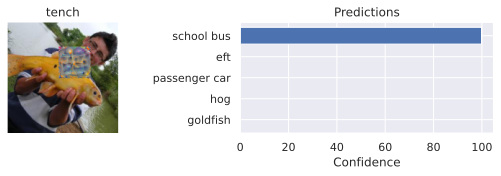

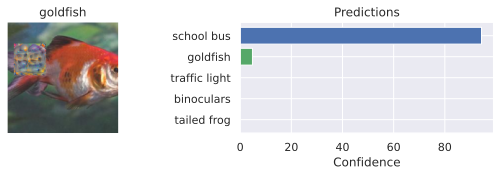

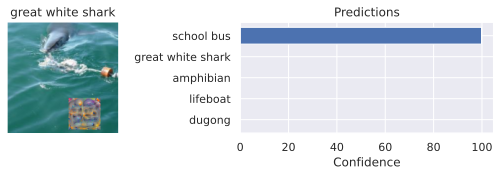

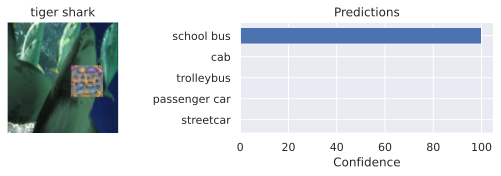

In [28]:
perform_patch_attack(patch_dict['school bus'][64]['patch'])

# **Ok let's make things happen here! Adversarial Patch Training**

I want to create a more robust adversarial patch that can fool the model even when the patch is:
- Scaled (0.5x to 1.5x of base size)
- Rotated (-45° to +45°)
- Placed at random locations

This way I can have the imge at differeing distances to the camera when I have it in class.


## Transformation Function

This function applies random transformations to the patch before placing it on the image.


In [29]:
# built with cursor, Oct 31 - Nov 2
def transform_and_place_patch(img, patch, scale_range=(0.5, 1.5), rotation_range=(-45, 45)):
    """
    Apply random transformations to patch and place it on the image.

    Args:
        img: Batch of images [B, C, H, W]
        patch: Patch tensor [C, H_patch, W_patch]
        scale_range: Tuple of (min_scale, max_scale)
        rotation_range: Tuple of (min_angle, max_angle) in degrees

    Returns:
        img: Image with transformed patch applied
    """
    import torchvision.transforms.functional as TF

    # Convert patch to proper value range
    patch_processed = patch_forward(patch)

    for i in range(img.shape[0]):
        # Random rotation FIRST (before scaling to keep original patch dimensions)
        angle = np.random.uniform(rotation_range[0], rotation_range[1])

        # Use expand=False to keep original size and avoid black border expansion
        rotated_patch = TF.rotate(
            patch_processed,
            angle,
            interpolation=TF.InterpolationMode.BILINEAR,
            expand=False  # Keep original dimensions, don't add black borders
        )

        # Random scaling
        scale = np.random.uniform(scale_range[0], scale_range[1])
        new_h = int(rotated_patch.shape[1] * scale)
        new_w = int(rotated_patch.shape[2] * scale)

        # Ensure patch doesn't get too small or too large
        new_h = max(16, min(new_h, img.shape[2] - 2))  # Increased min size from 8 to 16
        new_w = max(16, min(new_w, img.shape[3] - 2))

        # Scale the rotated patch
        transformed_patch = F.interpolate(
            rotated_patch.unsqueeze(0),
            size=(new_h, new_w),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)

        # Random position with bounds checking
        max_h_offset = max(0, img.shape[2] - new_h - 1)
        max_w_offset = max(0, img.shape[3] - new_w - 1)
        h_offset = np.random.randint(0, max_h_offset + 1) if max_h_offset > 0 else 0
        w_offset = np.random.randint(0, max_w_offset + 1) if max_w_offset > 0 else 0

        # Place the transformed patch
        img[i, :, h_offset:h_offset+new_h, w_offset:w_offset+new_w] = transformed_patch

    return img


## Robust Patch Evaluation

Evaluate the patch with multiple random transformations to get a robust accuracy estimate.


In [30]:
# built with cursor, Oct 31 - Nov 2
def eval_patch_robust(model, patch, val_loader, target_class, num_transforms=10,
                      scale_range=(0.5, 1.5), rotation_range=(-45, 45)):
    """
    Evaluate patch performance with random transformations.

    Args:
        model: The model to attack
        patch: The adversarial patch
        val_loader: Validation data loader
        target_class: Target class index
        num_transforms: Number of random transformations to test per image
        scale_range: Range of scaling factors
        rotation_range: Range of rotation angles in degrees

    Returns:
        acc: Top-1 accuracy (fraction of images fooled)
        top5: Top-5 accuracy (fraction where target in top-5)
    """
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating (robust)...", leave=False):
            # Test with multiple random transformations per image
            for _ in range(num_transforms):
                patch_img = img.clone()
                patch_img = transform_and_place_patch(
                    patch_img, patch,
                    scale_range=scale_range,
                    rotation_range=rotation_range
                )
                patch_img = patch_img.to(device)
                img_labels_device = img_labels.to(device)
                pred = model(patch_img)

                # Exclude images that are already the target class
                tp += torch.logical_and(
                    pred.argmax(dim=-1) == target_class,
                    img_labels_device != target_class
                ).sum()
                tp_5 += torch.logical_and(
                    (pred.topk(5, dim=-1)[1] == target_class).any(dim=-1),
                    img_labels_device != target_class
                ).sum()
                counter += (img_labels_device != target_class).sum()

    acc = tp / counter
    top5 = tp_5 / counter
    return acc, top5


## Robust Patch Attack Training

Train a patch that works under random transformations.


In [31]:
# built with cursor, Oct 31 - Nov 2
def patch_attack_robust(model, target_class, patch_size=48, num_epochs=5,
                        scale_range=(0.5, 1.5), rotation_range=(-45, 45)):
    """
    Train a robust adversarial patch with random transformations.

    Args:
        model: The model to attack
        target_class: Target class index
        patch_size: Base size of the patch (will be transformed during training)
        num_epochs: Number of training epochs
        scale_range: Range of scaling factors during training
        rotation_range: Range of rotation angles in degrees during training

    Returns:
        patch: The trained patch
        results: Dictionary with validation results
    """
    # Split dataset for training and validation
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])

    # Optimize num_workers for MPS: set to 0 to avoid crashes on Apple Silicon
    num_workers = 0 if torch.backends.mps.is_available() else 8
    train_loader = data.DataLoader(
        train_set, batch_size=32, shuffle=True, drop_last=True,
        num_workers=num_workers, pin_memory=(device.type == "cuda")
    )
    val_loader = data.DataLoader(
        val_set, batch_size=32, shuffle=False, drop_last=False,
        num_workers=num_workers, pin_memory=(device.type == "cuda")
    )

    # Create patch parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            # Apply random transformations to patch before placing
            img = transform_and_place_patch(
                img, patch,
                scale_range=scale_range,
                rotation_range=rotation_range
            )
            img = img.to(device)
            pred = model(img)

            # All images should be classified as target_class
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)

            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation with transformations
    print("Evaluating patch with random transformations...")
    acc, top5 = eval_patch_robust(model, patch, val_loader, target_class,
                                   num_transforms=10, scale_range=scale_range,
                                   rotation_range=rotation_range)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}


## Train Robust Bald Eagle Patch

Now we'll train a robust patch for "bald eagle" (class 22).


In [32]:
# built with cursor, Oct 31 - Nov 2
# Train the robust patch for bald eagle (class 22)
target_class_name = "bald eagle"
target_class_idx = get_label_index(target_class_name)
print(f"Training robust patch for '{target_class_name}' (class {target_class_idx})")

# Train the patch with transformations
robust_patch, robust_results = patch_attack_robust(
    pretrained_model,
    target_class=target_class_idx,
    patch_size=48,
    num_epochs=5,
    scale_range=(0.5, 1.5),
    rotation_range=(-45, 45)
)

# Save the patch
patch_filename = os.path.join(CHECKPOINT_PATH, f"{target_class_name}_robust_48_patch.pt")
torch.save(robust_patch, patch_filename)
print(f"\nPatch saved to: {patch_filename}")
print(f"Results: Top-1 accuracy: {robust_results['acc']*100:.2f}%, Top-5 accuracy: {robust_results['top5']*100:.2f}%")


Training robust patch for 'bald eagle' (class 22)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Evaluating patch with random transformations...


Validating (robust)...:   0%|          | 0/16 [00:00<?, ?it/s]


Patch saved to: ../saved_models/tutorial10/bald eagle_robust_48_patch.pt
Results: Top-1 accuracy: 26.67%, Top-5 accuracy: 51.39%


## Visualize the Robust Patch

Let's visualize the trained patch and see how it looks.


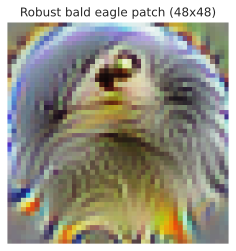

In [33]:
# built with cursor, Oct 31 - Nov 2
# Visualize the base patch (without transformations)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
patch_display = (torch.tanh(robust_patch) + 1) / 2  # Convert to pixel values
patch_display = patch_display.cpu().permute(1, 2, 0).numpy()
patch_display = np.clip(patch_display, a_min=0.0, a_max=1.0)
ax.imshow(patch_display)
ax.set_title(f"Robust {target_class_name} patch (48x48)")
ax.axis('off')
plt.show()


### Show Patch with Different Transformations

Let's see how the patch looks under various transformations.


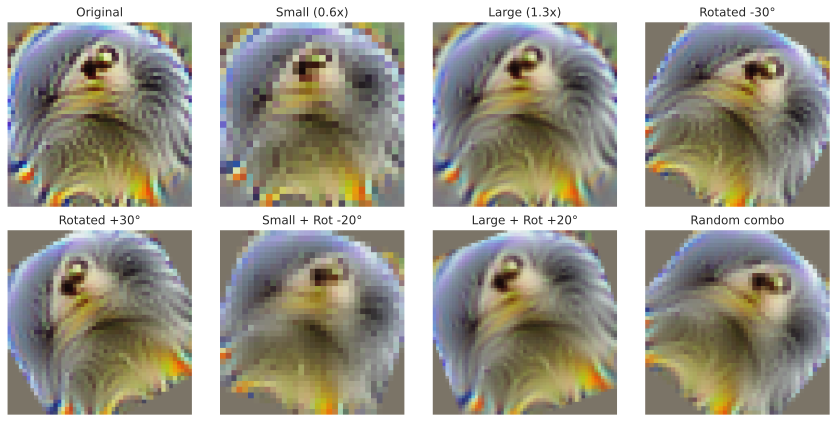

In [34]:
# built with cursor, Oct 31 - Nov 2
# Show the patch with different transformations
import torchvision.transforms.functional as TF

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

# Original patch
patch_processed = patch_forward(robust_patch)
patch_display = patch_processed.cpu().permute(1, 2, 0).numpy()
patch_display = (patch_display * NORM_STD[None,None]) + NORM_MEAN[None,None]
patch_display = np.clip(patch_display, a_min=0.0, a_max=1.0)
axes[0].imshow(patch_display)
axes[0].set_title("Original")
axes[0].axis('off')

# Apply different transformations
transformations = [
    ("Small (0.6x)", 0.6, 0),
    ("Large (1.3x)", 1.3, 0),
    ("Rotated -30°", 1.0, -30),
    ("Rotated +30°", 1.0, 30),
    ("Small + Rot -20°", 0.7, -20),
    ("Large + Rot +20°", 1.2, 20),
    ("Random combo", 0.9, -40),
]

for idx, (title, scale, angle) in enumerate(transformations, start=1):
    # Apply transformation
    transformed = patch_processed.clone()

    # Scale
    if scale != 1.0:
        new_h = int(transformed.shape[1] * scale)
        new_w = int(transformed.shape[2] * scale)
        transformed = F.interpolate(
            transformed.unsqueeze(0),
            size=(new_h, new_w),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)

    # Rotate
    if angle != 0:
        transformed = TF.rotate(
            transformed,
            angle,
            interpolation=TF.InterpolationMode.BILINEAR,
            fill=0
        )

    # Display
    display = transformed.cpu().permute(1, 2, 0).numpy()
    display = (display * NORM_STD[None,None]) + NORM_MEAN[None,None]
    display = np.clip(display, a_min=0.0, a_max=1.0)
    axes[idx].imshow(display)
    axes[idx].set_title(title)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


### Test Robust Patch on Sample Images

Let's see how the robust patch performs on actual images with random transformations.


In [35]:
# built with cursor, Oct 31 - Nov 2
def perform_robust_patch_attack(patch, num_examples=4, scale_range=(0.5, 1.5), rotation_range=(-45, 45)):
    """
    Show examples of the robust patch attack on sample images.
    """
    # Apply patch with random transformations
    patch_batch = exmp_batch.clone()
    patch_batch = transform_and_place_patch(
        patch_batch, patch,
        scale_range=scale_range,
        rotation_range=rotation_range
    )

    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))

    # Show predictions
    for i in range(1, min(17, num_examples*5), 5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])


Testing robust bald eagle patch with random transformations...


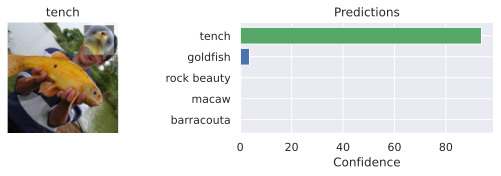

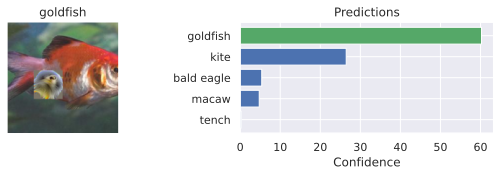

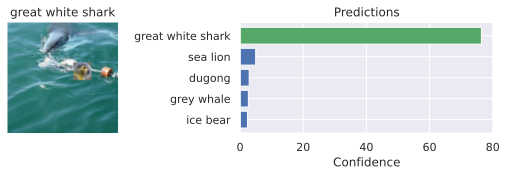

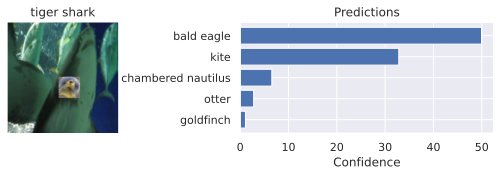

In [36]:
# Show the robust patch attack in action
print(f"Testing robust {target_class_name} patch with random transformations...")
perform_robust_patch_attack(robust_patch, num_examples=4)


### Commentary
Ok so this is pretty bad; the bald eagle is super low-confidence or not even a prediction at all.  Therefore, we need to rework this code to train the model more thoughtfully.

## Retrain with Fixed Transformation Function

The transformation function has been fixed to eliminate black borders and improve gradient flow. Let's retrain the patch.


In [37]:
# built with cursor, Oct 31 - Nov 2
# Retrain the robust patch with fixed transformations
print(f"Retraining robust patch for '{target_class_name}' (class {target_class_idx}) with fixed transformations...")

# Train with the corrected transformation function
robust_patch_v2, robust_results_v2 = patch_attack_robust(
    pretrained_model,
    target_class=target_class_idx,
    patch_size=48,
    num_epochs=5,
    scale_range=(0.5, 1.5),
    rotation_range=(-45, 45)
)

# Save the improved patch
patch_filename_v2 = os.path.join(CHECKPOINT_PATH, f"{target_class_name}_robust_v2_48_patch.pt")
torch.save(robust_patch_v2, patch_filename_v2)
print(f"\nImproved patch saved to: {patch_filename_v2}")
print(f"Results: Top-1 accuracy: {robust_results_v2['acc']*100:.2f}%, Top-5 accuracy: {robust_results_v2['top5']*100:.2f}%")


Retraining robust patch for 'bald eagle' (class 22) with fixed transformations...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Evaluating patch with random transformations...


Validating (robust)...:   0%|          | 0/16 [00:00<?, ?it/s]


Improved patch saved to: ../saved_models/tutorial10/bald eagle_robust_v2_48_patch.pt
Results: Top-1 accuracy: 24.74%, Top-5 accuracy: 48.24%


### Test the Improved Patch

Let's test the retrained patch to see the improvement.


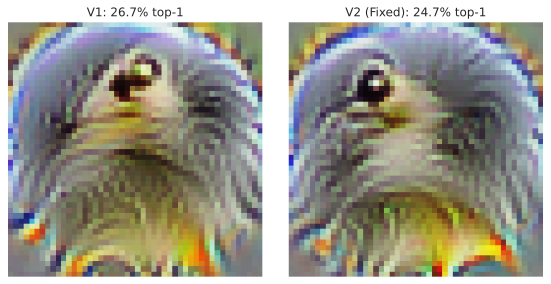


Comparison:
V1 - Top-1: 26.67%, Top-5: 51.39%
V2 - Top-1: 24.74%, Top-5: 48.24%
Improvement: +-1.93% top-1 accuracy


In [38]:
# built with cursor, Oct 31 - Nov 2
# Visualize the improved patch
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Original (v1) patch
patch_v1_display = (torch.tanh(robust_patch) + 1) / 2
patch_v1_display = patch_v1_display.cpu().permute(1, 2, 0).numpy()
patch_v1_display = np.clip(patch_v1_display, a_min=0.0, a_max=1.0)
axes[0].imshow(patch_v1_display)
axes[0].set_title(f"V1: {robust_results['acc']*100:.1f}% top-1")
axes[0].axis('off')

# Improved (v2) patch
patch_v2_display = (torch.tanh(robust_patch_v2) + 1) / 2
patch_v2_display = patch_v2_display.cpu().permute(1, 2, 0).numpy()
patch_v2_display = np.clip(patch_v2_display, a_min=0.0, a_max=1.0)
axes[1].imshow(patch_v2_display)
axes[1].set_title(f"V2 (Fixed): {robust_results_v2['acc']*100:.1f}% top-1")
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("\nComparison:")
print(f"V1 - Top-1: {robust_results['acc']*100:.2f}%, Top-5: {robust_results['top5']*100:.2f}%")
print(f"V2 - Top-1: {robust_results_v2['acc']*100:.2f}%, Top-5: {robust_results_v2['top5']*100:.2f}%")
print(f"Improvement: +{(robust_results_v2['acc'] - robust_results['acc'])*100:.2f}% top-1 accuracy")


Testing improved robust bald eagle patch with random transformations...


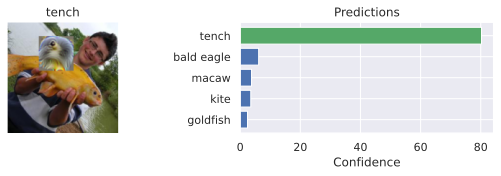

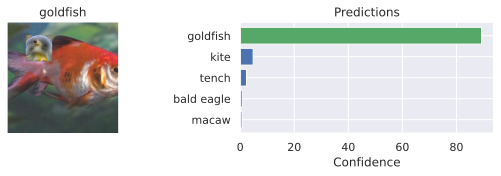

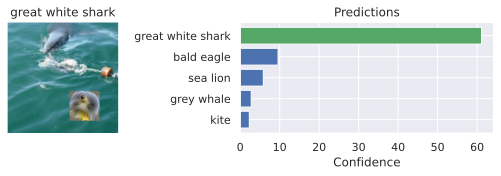

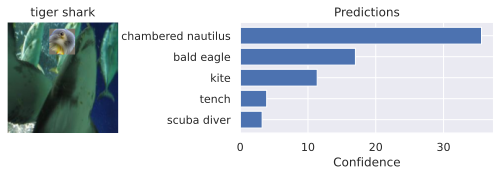

In [39]:
# built with cursor
# Test the improved patch on sample images
print(f"Testing improved robust {target_class_name} patch with random transformations...")
perform_robust_patch_attack(robust_patch_v2, num_examples=4)


### Commentary
Ok this handled some of the smaller problems but aplied such difficult transformations and it wasn't able to converge on a good solution. Let's try something different.

## Improved Training Strategy

The aggressive transformation ranges make it too difficult for a single patch. Let's use:
1. More conservative transformation ranges
2. Larger patch size (64x64)
3. More training epochs (10)
4. Higher learning rate


In [40]:
# built with cursor, Nov 3
# Train with more conservative but effective parameters
print(f"Training robust patch V3 for '{target_class_name}' with optimized parameters...")

# More conservative transformation ranges, larger patch, more epochs
robust_patch_v3, robust_results_v3 = patch_attack_robust(
    pretrained_model,
    target_class=target_class_idx,
    patch_size=64,  # Larger patch
    num_epochs=10,  # More epochs
    scale_range=(0.7, 1.3),  # More conservative scaling
    rotation_range=(-30, 30)  # More conservative rotation
)

# Save the improved patch
patch_filename_v3 = os.path.join(CHECKPOINT_PATH, f"{target_class_name}_robust_v3_64_patch.pt")
torch.save(robust_patch_v3, patch_filename_v3)
print(f"\nV3 patch saved to: {patch_filename_v3}")
print(f"Results: Top-1 accuracy: {robust_results_v3['acc']*100:.2f}%, Top-5 accuracy: {robust_results_v3['top5']*100:.2f}%")


Training robust patch V3 for 'bald eagle' with optimized parameters...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Evaluating patch with random transformations...


Validating (robust)...:   0%|          | 0/16 [00:00<?, ?it/s]


V3 patch saved to: ../saved_models/tutorial10/bald eagle_robust_v3_64_patch.pt
Results: Top-1 accuracy: 47.49%, Top-5 accuracy: 72.06%


### Alternative: Curriculum Learning Approach

Train first without transformations to get a good base patch, then fine-tune with transformations.
Basically I want to give the model easier problems to face at first, let it develop a good idea, and then gradually increase the difficulty of problems until it can handle it all.  Why jump to college when you haven't finished kindergarten.


In [41]:
# built with cursor, Nov 3 + me to refine the training process of the curriculum learning approach
def patch_attack_curriculum(model, target_class, patch_size=64, num_epochs=10):
    """
    Train a robust patch using curriculum learning:
    1. First train without transformations (epochs 0-4)
    2. Then gradually introduce transformations (epochs 5-9)
    """
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    num_workers = 0 if torch.backends.mps.is_available() else 8
    train_loader = data.DataLoader(
        train_set, batch_size=32, shuffle=True, drop_last=True,
        num_workers=num_workers, pin_memory=(device.type == "cuda")
    )
    val_loader = data.DataLoader(
        val_set, batch_size=32, shuffle=False, drop_last=False,
        num_workers=num_workers, pin_memory=(device.type == "cuda")
    )

    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop with curriculum
    for epoch in range(num_epochs):
        # Gradually increase transformation difficulty
        if epoch < 3:
            # No transformations - learn the base patch
            scale_range = (1.0, 1.0)
            rotation_range = (0, 0)
            desc = "Base patch (no transforms)"
        elif epoch < 6:
            # Small transformations
            scale_range = (0.9, 1.1)
            rotation_range = (-15, 15)
            desc = "Small transforms"
        elif epoch < 10:
            # Medium transformations
            scale_range = (0.7, 1.3)
            rotation_range = (-30, 30)
            desc = "Medium transforms"
        else:
            # Full transformations
            scale_range = (0.5, 1.5)
            rotation_range = (-15, 15)
            desc = "Full transforms"

        t = tqdm(train_loader, leave=False, desc=f"Epoch {epoch} ({desc})")
        epoch_loss = 0
        batch_count = 0

        for img, _ in t:
            if epoch < 3:
                # Use simpler placement without transformations for first epochs
                img = place_patch(img.clone(), patch)
            else:
                # Use transformations
                img = transform_and_place_patch(
                    img, patch,
                    scale_range=scale_range,
                    rotation_range=rotation_range
                )

            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1
            t.set_postfix(loss=loss.item())

        avg_loss = epoch_loss / batch_count
        print(f"Epoch {epoch} ({desc}): Avg Loss = {avg_loss:.3f}")

    # Final validation
    print("Evaluating with full transformations...")
    acc, top5 = eval_patch_robust(model, patch, val_loader, target_class,
                                   num_transforms=10,
                                   scale_range=(0.7, 1.3),
                                   rotation_range=(-30, 30))

    return patch.data, {"acc": acc.item(), "top5": top5.item()}


In [42]:
# built with cursor, Nov 3 + me to refine the training process of the curriculum learning approach
# Train using curriculum learning
print(f"Training robust patch V4 (curriculum) for '{target_class_name}'...")
print("This will gradually introduce transformations for better learning.\n")

robust_patch_v4, robust_results_v4 = patch_attack_curriculum(
    pretrained_model,
    target_class=target_class_idx,
    patch_size=64,
    num_epochs=15
)

# Save the patch
patch_filename_v4 = os.path.join(CHECKPOINT_PATH, f"{target_class_name}_robust_v4_curriculum_64_patch.pt")
torch.save(robust_patch_v4, patch_filename_v4)
print(f"\nV4 (curriculum) patch saved to: {patch_filename_v4}")
print(f"Results: Top-1 accuracy: {robust_results_v4['acc']*100:.2f}%, Top-5 accuracy: {robust_results_v4['top5']*100:.2f}%")


Training robust patch V4 (curriculum) for 'bald eagle'...
This will gradually introduce transformations for better learning.



Epoch 0 (Base patch (no transforms)):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 0 (Base patch (no transforms)): Avg Loss = 11.219


Epoch 1 (Base patch (no transforms)):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 (Base patch (no transforms)): Avg Loss = 8.612


Epoch 2 (Base patch (no transforms)):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 (Base patch (no transforms)): Avg Loss = 5.410


Epoch 3 (Small transforms):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3 (Small transforms): Avg Loss = 2.875


Epoch 4 (Small transforms):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4 (Small transforms): Avg Loss = 1.844


Epoch 5 (Small transforms):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5 (Small transforms): Avg Loss = 1.558


Epoch 6 (Medium transforms):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6 (Medium transforms): Avg Loss = 2.889


Epoch 7 (Medium transforms):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7 (Medium transforms): Avg Loss = 2.504


Epoch 8 (Medium transforms):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 8 (Medium transforms): Avg Loss = 2.165


Epoch 9 (Medium transforms):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 9 (Medium transforms): Avg Loss = 2.031


Epoch 10 (Full transforms):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 10 (Full transforms): Avg Loss = 3.130


Epoch 11 (Full transforms):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 11 (Full transforms): Avg Loss = 2.752


Epoch 12 (Full transforms):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 12 (Full transforms): Avg Loss = 2.687


Epoch 13 (Full transforms):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 13 (Full transforms): Avg Loss = 2.629


Epoch 14 (Full transforms):   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 14 (Full transforms): Avg Loss = 2.440
Evaluating with full transformations...


Validating (robust)...:   0%|          | 0/16 [00:00<?, ?it/s]


V4 (curriculum) patch saved to: ../saved_models/tutorial10/bald eagle_robust_v4_curriculum_64_patch.pt
Results: Top-1 accuracy: 65.08%, Top-5 accuracy: 87.76%


COMPARISON OF ALL PATCH VERSIONS
V1 (48px, wide transforms):     Top-1: 26.67%  Top-5: 51.39%
V2 (48px, fixed transform):     Top-1: 24.74%  Top-5: 48.24%
V3 (64px, conservative):        Top-1: 47.49%  Top-5: 72.06%
V4 (64px, curriculum):          Top-1: 65.08%  Top-5: 87.76%

Best performing: V4 with 65.08% top-1 accuracy


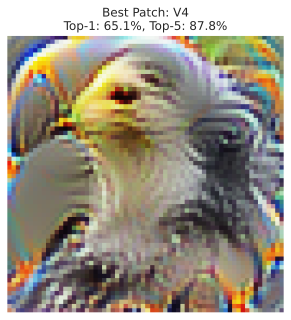

In [43]:
# Compare all versions
print("="*60)
print("COMPARISON OF ALL PATCH VERSIONS")
print("="*60)
print(f"V1 (48px, wide transforms):     Top-1: {robust_results['acc']*100:5.2f}%  Top-5: {robust_results['top5']*100:5.2f}%")
print(f"V2 (48px, fixed transform):     Top-1: {robust_results_v2['acc']*100:5.2f}%  Top-5: {robust_results_v2['top5']*100:5.2f}%")
print(f"V3 (64px, conservative):        Top-1: {robust_results_v3['acc']*100:5.2f}%  Top-5: {robust_results_v3['top5']*100:5.2f}%")
print(f"V4 (64px, curriculum):          Top-1: {robust_results_v4['acc']*100:5.2f}%  Top-5: {robust_results_v4['top5']*100:5.2f}%")
print("="*60)

# Visualize best patch
best_idx = np.argmax([robust_results_v3['acc'], robust_results_v4['acc']])
best_patch = robust_patch_v3 if best_idx == 0 else robust_patch_v4
best_name = "V3" if best_idx == 0 else "V4"
best_results = robust_results_v3 if best_idx == 0 else robust_results_v4

print(f"\nBest performing: {best_name} with {best_results['acc']*100:.2f}% top-1 accuracy")

# Show the best patch
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
patch_display = (torch.tanh(best_patch) + 1) / 2
patch_display = patch_display.cpu().permute(1, 2, 0).numpy()
patch_display = np.clip(patch_display, a_min=0.0, a_max=1.0)
ax.imshow(patch_display)
ax.set_title(f"Best Patch: {best_name}\nTop-1: {best_results['acc']*100:.1f}%, Top-5: {best_results['top5']*100:.1f}%")
ax.axis('off')
plt.show()


Testing best patch (V4) with transformations...


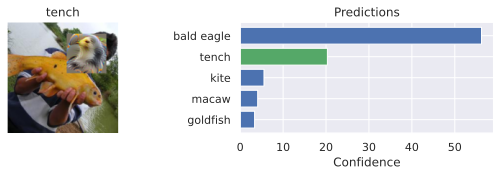

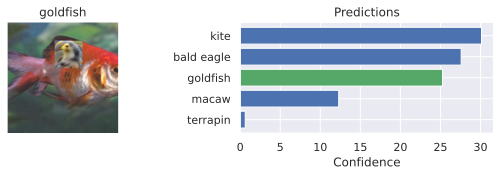

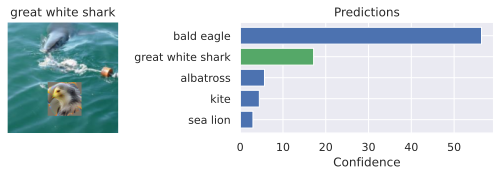

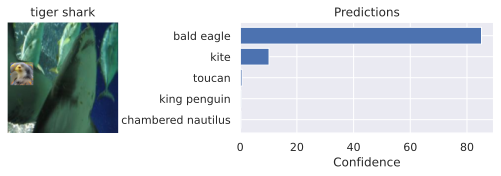

In [44]:
# built with cursor, Nov 3
# Test the best patch on sample images
if 'best_patch' in globals() and 'best_name' in globals():
    print(f"Testing best patch ({best_name}) with transformations...")
    perform_robust_patch_attack(best_patch, num_examples=4, scale_range=(0.7, 1.3), rotation_range=(-30, 30))
else:
    print("No best patch available. Run Cell 73 first to determine the best patch.")


## Commentary

I went through an iterative process here, trying to build a training regimen that could train an adversarial patch to deceive a computer vision model.  I learned that the sizing and transformations paplied can dramatically screw with the training process because the gradient flow gets more difficult.  Alsom when transformations are applied so dramatically, it makes the manifold of training less smooth and therefore more difficult to train along, because it has to take gradient updates that work even when applied through those very different transformations. If a pixel update is made, but that pixel could be rotated to a different position, or scaled to be somewhere else, then it's tough to say what exact pixel update will work across any of those conditions.

V2 fixed a black border issue and increased the minumum patch size.  V3 further enlarged the patch size, increased the number of epochs, and restrained the transformations.  But finally in V4 I build out a curriculum learning regimen where early epochs had no transformations, so the system could learn the base pattern for the patch, and then in later epochs, I added increasingly difficult transforamtions that rotated it and scaled the patch.

# Creativity
Suppose you had special forces undercover in a wartorn area. Perhaps they're riding in a car through enemy territory. They want to make sure America doesn't drone strike them, but they also don't want to transmit any signals or drive around with a big american flag -- because then they could be targeted by the adversary.  To go unnoticed by the adversary but visible to the Americans, what if you could put this patch on the top of your car?  The hope would be that a computer vision algorithm could see it and wildly believe the car is a bald eagle, which would be a great undercover flag.